# Finding the MRI brain tumor detection dataset

Let's find the dataset in this link: https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection

# Import packages

In [12]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import random
import cv2
import sys

## Reading the Images

In [2]:
tumor = []
healthy = []
for f in glob.iglob("./data/brain_tumor_dataset/yes/*.jpg"):
    img = cv2.imread(f)
    img = cv2.resize(img,(128,128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])
    tumor.append(img)

for f in glob.iglob("./data/brain_tumor_dataset/no/*.jpg"):
    img = cv2.imread(f)
    img = cv2.resize(img,(128,128)) 
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])
    healthy.append(img)

In [3]:
healthy = np.array(healthy)
tumor = np.array(tumor)
All = np.concatenate((healthy, tumor))

In [4]:
healthy.shape

(91, 128, 128, 3)

In [5]:
tumor.shape

(154, 128, 128, 3)

In [6]:
np.random.choice(10, 5, replace=False)

array([3, 0, 5, 8, 7])

# Visualizing Brain MRI Images

In [7]:
def plot_random(healthy, tumor, num=5):
    healthy_imgs = healthy[np.random.choice(healthy.shape[0], num, replace=False)]
    tumor_imgs = tumor[np.random.choice(tumor.shape[0], num, replace=False)]
    
    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('healthy')
        plt.imshow(healthy_imgs[i])
        
    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('tumor')
        plt.imshow(tumor_imgs[i])
        
        

    

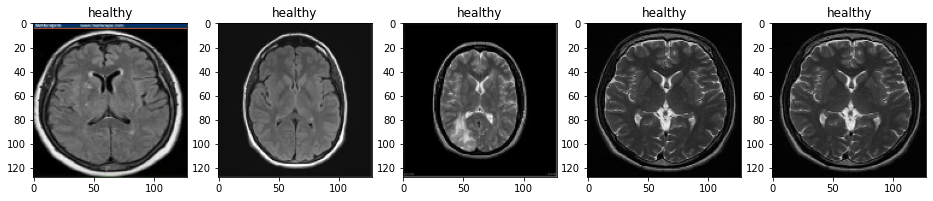

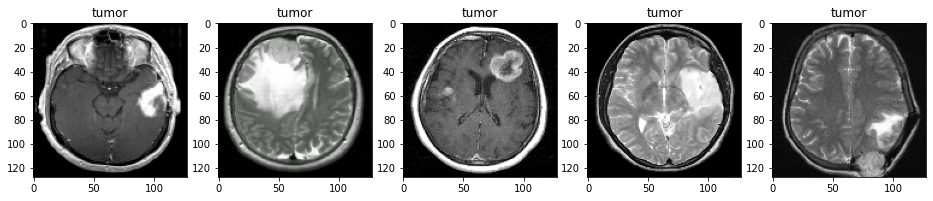

In [8]:
plot_random(healthy, tumor, num=5)

 # Create Torch Dataset Class

## What is Pytorch's Abstract Dataset Class

In [9]:
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])

## Creating MRI cutom dataset class 

In [10]:
class MRI(Dataset):
    def __init__(self):
        
        tumor = []
        healthy = []
        # cv2 - It reads in BGR format by default
        for f in glob.iglob("./data/brain_tumor_dataset/yes/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) # I can add this later in the boot-camp for more adventure
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1])) # otherwise the shape will be (h,w,#channels)
            tumor.append(img)

        for f in glob.iglob("./data/brain_tumor_dataset/no/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) 
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            healthy.append(img)

        # our images
        tumor = np.array(tumor,dtype=np.float32)
        healthy = np.array(healthy,dtype=np.float32)
        
        # our labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)
        
        # Concatenates
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))
        
    def __len__(self):
        return self.images.shape[0]
    
    def __getitem__(self, index):
        
        sample = {'image': self.images[index], 'label':self.labels[index]}
        
        return sample
    
    def normalize(self):
        self.images = self.images/255.0

In [11]:
mri_dataset = MRI()
mri_dataset.normalize()

# Creating a dataloader

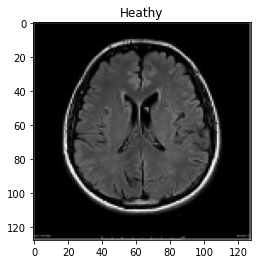

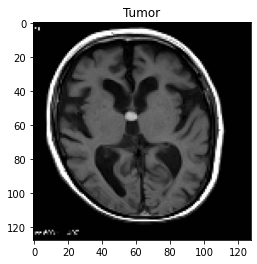

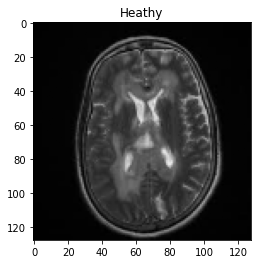

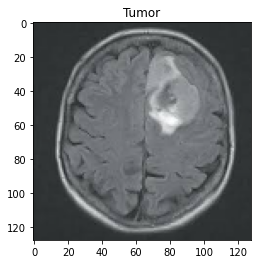

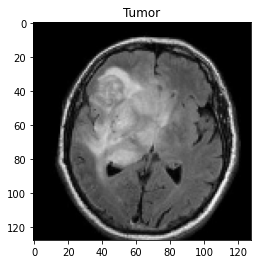

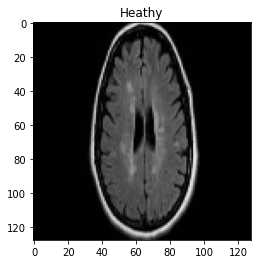

In [12]:
# One way of iterating
names={0:'Heathy', 1:'Tumor'}
dataloader = DataLoader(mri_dataset, shuffle=True)
for i, sample in enumerate(dataloader):
    img = sample['image'].squeeze()
    img = img.reshape((img.shape[1], img.shape[2], img.shape[0]))
    plt.title(names[sample['label'].item()])
    plt.imshow(img)
    plt.show()
    if i == 5:
        break

# Create a model

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.cnn_model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5))
        
        self.fc_model = nn.Sequential(
        nn.Linear(in_features=256, out_features=120),
        nn.Tanh(),
        nn.Linear(in_features=120, out_features=84),
        nn.Tanh(),
        nn.Linear(in_features=84, out_features=1))
        
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        x = F.sigmoid(x)
        
        return x
            

# Some Basics of Training and Evaluation in Pytorch

## model.eval()

- Used particularly for inference **NOTHING to DO with gradients!!!**
- changes the forward() behaviour of the module it is called up on eg, it disables dropout and has batch norm use the entire population statistics. This is necessary for inference

## model.train()

- Brings drop out and batch norm to action (i.e., train mode). 
- Gradients are computed

## numpy array vs tensor

The difference between a NumPy array and a tensor is that the tensors are backed by the accelerator memory like GPU and they are immutable, unlike NumPy arrays. You can never update a tensor but create a new one. If you are into machine learning or going to be into it, A Tensor is a suitable choice if you are going to use GPU. A tensor can reside in accelerator’s memory.

- The numpy arrays are the core functionality of the numpy package designed to support faster mathematical operations. Unlike python’s inbuilt list data structure, they can only hold elements of a single data type. Library like pandas which is used for data preprocessing is built around the numpy array. **Pytorch tensors are similar to numpy arrays, but can also be operated on CUDA-capable Nvidia GPU.**
- Numpy arrays are mainly used in typical machine learning algorithms (such as k-means or Decision Tree in scikit-learn) whereas pytorch tensors are mainly used in deep learning which requires heavy matrix computation.
- Unlike numpy arrays, while creating pytorch tensor, it also accepts two other arguments called the device_type (whether the computation happens on CPU or GPU) and the requires_grad (which is used to compute the derivatives).

## torch.tensor vs. torch.cuda.tensor

he key difference is just that torch.Tensor occupies CPU memory while torch.cuda.Tensor occupies GPU memory. Of course operations on a CPU Tensor are computed with CPU while operations for the GPU / CUDA Tensor are computed on GPU.

In [14]:
# device will be 'cuda' if a GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# creating a CPU tensor
cpu_tensor = torch.rand(10).to(device)
# moving same tensor to GPU
gpu_tensor = cpu_tensor.to(device)

print(cpu_tensor, cpu_tensor.dtype, type(cpu_tensor), cpu_tensor.type())
print(gpu_tensor, gpu_tensor.dtype, type(gpu_tensor), gpu_tensor.type())

print(cpu_tensor*gpu_tensor)

tensor([0.9542, 0.9316, 0.4195, 0.2183, 0.5101, 0.6611, 0.1521, 0.6089, 0.6189,
        0.4489], device='cuda:0') torch.float32 <class 'torch.Tensor'> torch.cuda.FloatTensor
tensor([0.9542, 0.9316, 0.4195, 0.2183, 0.5101, 0.6611, 0.1521, 0.6089, 0.6189,
        0.4489], device='cuda:0') torch.float32 <class 'torch.Tensor'> torch.cuda.FloatTensor
tensor([0.9104, 0.8679, 0.1760, 0.0476, 0.2602, 0.4370, 0.0231, 0.3707, 0.3830,
        0.2015], device='cuda:0')


As the underlying hardware interface is completely different, CPU Tensors are just compatible with CPU Tensor and vice versa GPU Tensors are just compatible to GPU Tensors.

### In which scenario is torch.cuda.Tensor() necessary?

When you want to use GPU acceleration (which is much faster in most cases) for your program, you need to use torch.cuda.Tensor, but you have to make sure that ALL tensors you are using are CUDA Tensors, mixing is not possible here.

### tensor.cpu().detach().numpy(): Convert Pytorch tensor to Numpy array

As mentioned before, np.ndarray object does not have this extra "computational graph" layer and therefore, when converting a torch.tensor to np.ndarray you must explicitly remove the computational graph of the tensor using the detach() command.
.cpu() returns a copy of this object in CPU memory.

# Evaluate a New-Born Neural Network!

In [14]:
mri_dataset = MRI()
mri_dataset.normalize()
device = torch.device('cuda:0')
model = CNN().to(device)

In [15]:
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

In [16]:
model.eval()
outputs = []
y_true = []
with torch.no_grad():
    for D in dataloader:
        image = D['image'].to(device)
        label = D['label'].to(device)

        y_hat = model(image)

        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())
    


C:\Users\mehra\anaconda3\envs\ANN\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [17]:
outputs = np.concatenate( outputs, axis=0 ).squeeze()
y_true = np.concatenate( y_true, axis=0 ).squeeze()

In [18]:
def threshold(scores,threshold=0.50, minimum=0, maximum = 1.0):
    x = np.array(list(scores))
    x[x >= threshold] = maximum
    x[x < threshold] = minimum
    return x

In [19]:
accuracy_score(y_true, threshold(outputs))

0.37142857142857144

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

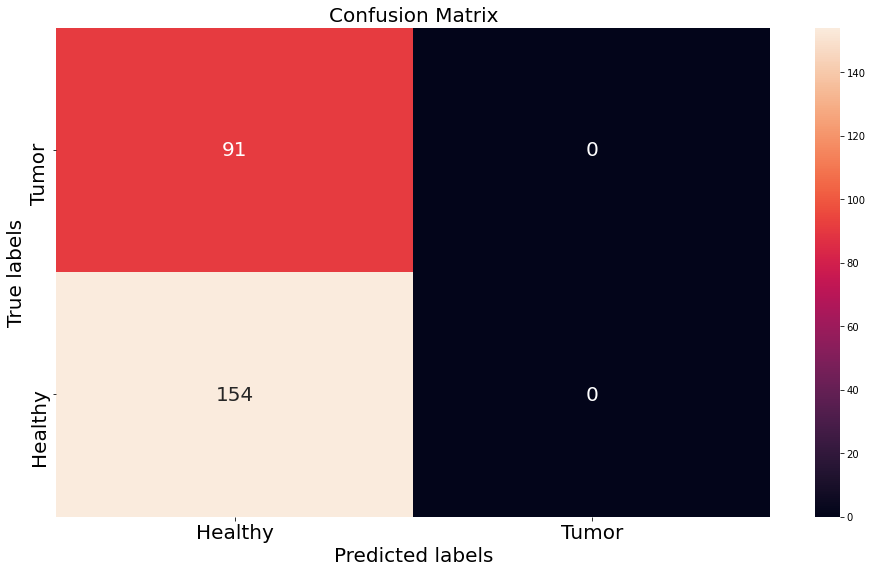

In [20]:
# a better confusion matrix
import seaborn as sns

plt.figure(figsize=(16,9))
cm = confusion_matrix(y_true, threshold(outputs))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={"size": 20})

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize=20)
ax.set_ylabel('True labels', fontsize=20) 
ax.set_title('Confusion Matrix', fontsize=20)
ax.xaxis.set_ticklabels(['Healthy','Tumor'], fontsize=20)
ax.yaxis.set_ticklabels(['Tumor','Healthy'], fontsize=20)

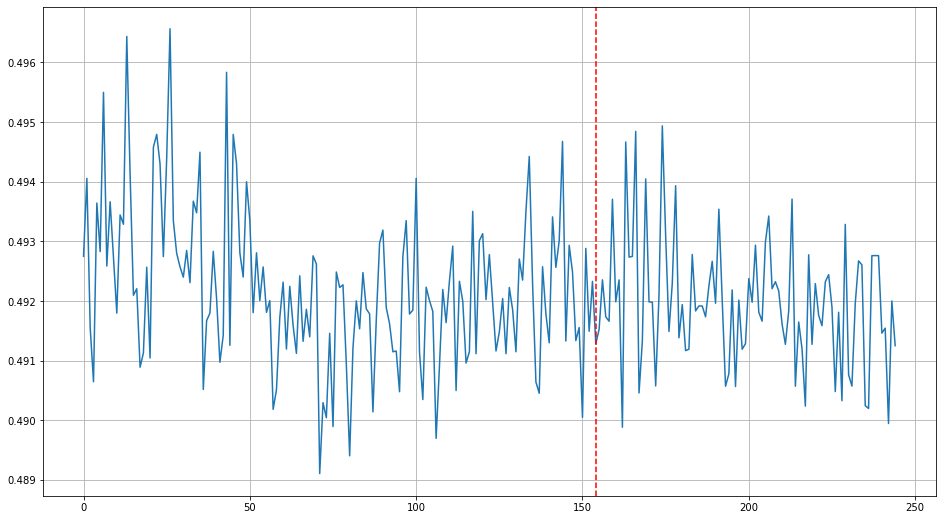

In [21]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()

# Train the dumb model

In [22]:
eta = 0.0001
EPOCH = 400
optimizer = torch.optim.Adam(model.parameters(), lr=eta)
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
model.train()

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [23]:
for epoch in range(1, EPOCH):
    losses = []
    for D in dataloader:
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        y_hat = model(data)
        # define loss function
        error = nn.BCELoss() 
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tLoss: {:.6f}'.format(epoch+1, np.mean(losses)))

C:\Users\mehra\anaconda3\envs\ANN\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 10	Loss: 0.623023
Train Epoch: 20	Loss: 0.592170
Train Epoch: 30	Loss: 0.538834
Train Epoch: 40	Loss: 0.526134
Train Epoch: 50	Loss: 0.505881
Train Epoch: 60	Loss: 0.490510
Train Epoch: 70	Loss: 0.465645
Train Epoch: 80	Loss: 0.451624
Train Epoch: 90	Loss: 0.430329
Train Epoch: 100	Loss: 0.416591
Train Epoch: 110	Loss: 0.392033
Train Epoch: 120	Loss: 0.368490
Train Epoch: 130	Loss: 0.343999
Train Epoch: 140	Loss: 0.318811
Train Epoch: 150	Loss: 0.302641
Train Epoch: 160	Loss: 0.276192
Train Epoch: 170	Loss: 0.252214
Train Epoch: 180	Loss: 0.234675
Train Epoch: 190	Loss: 0.211978
Train Epoch: 200	Loss: 0.189681
Train Epoch: 210	Loss: 0.173892
Train Epoch: 220	Loss: 0.158063
Train Epoch: 230	Loss: 0.134982
Train Epoch: 240	Loss: 0.118089
Train Epoch: 250	Loss: 0.099290
Train Epoch: 260	Loss: 0.085761
Train Epoch: 270	Loss: 0.070196
Train Epoch: 280	Loss: 0.060507
Train Epoch: 290	Loss: 0.048033
Train Epoch: 300	Loss: 0.039793
Train Epoch: 310	Loss: 0.032209
Train Epoch: 320	

# Evaluate a smart model

In [24]:
model.eval()
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)
outputs=[]
y_true = []
with torch.no_grad():
    for D in dataloader:
        image =  D['image'].to(device)
        label = D['label'].to(device)
        
        y_hat = model(image)
        
        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())
        
outputs = np.concatenate( outputs, axis=0 )
y_true = np.concatenate( y_true, axis=0 )

C:\Users\mehra\anaconda3\envs\ANN\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [25]:
accuracy_score(y_true, threshold(outputs))

1.0

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

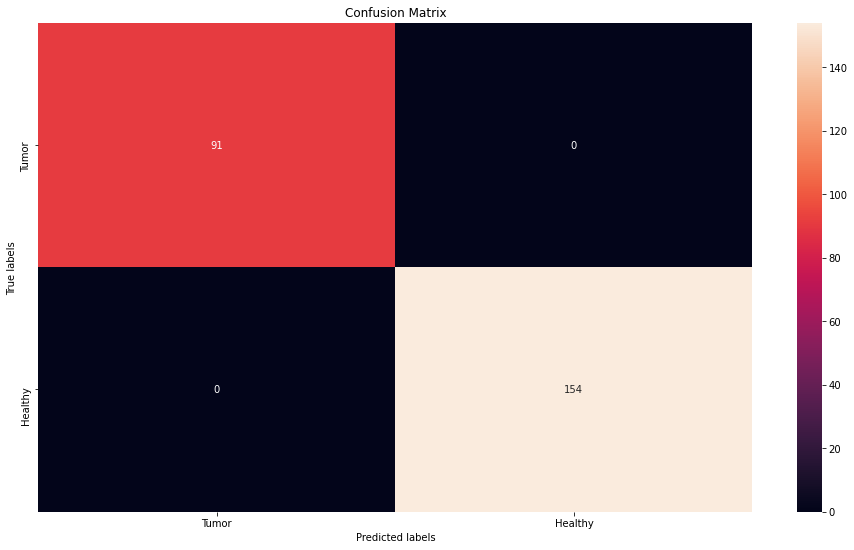

In [26]:
cm = confusion_matrix(y_true, threshold(outputs))
plt.figure(figsize=(16,9))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Tumor','Healthy'])
ax.yaxis.set_ticklabels(['Tumor','Healthy'])

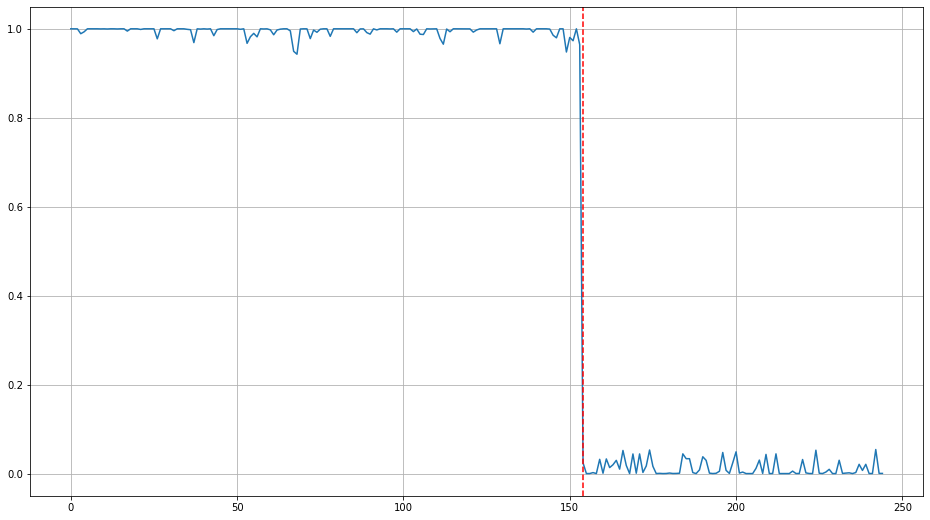

In [27]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()

# Visualising the Feature Maps of the Convolutional Filters

In [29]:
model

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [30]:
no_of_layers = 0
conv_layers = []

In [35]:
model_children = list(model.children())
model_children

[Sequential(
   (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
   (1): Tanh()
   (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
   (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
   (4): Tanh()
   (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
 ), Sequential(
   (0): Linear(in_features=256, out_features=120, bias=True)
   (1): Tanh()
   (2): Linear(in_features=120, out_features=84, bias=True)
   (3): Tanh()
   (4): Linear(in_features=84, out_features=1, bias=True)
 )]

In [36]:
for child in model_children:
    if type(child) == nn.Sequential:
        for layer in child.children():
            if type(layer) == nn.Conv2d:
                no_of_layers += 1
                conv_layers.append(layer)

In [45]:
conv_layers

[Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1)),
 Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))]

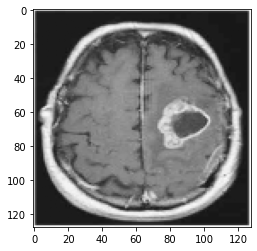

In [40]:
img = mri_dataset[100]['image']
plt.imshow(img.reshape(128,128,3))

In [41]:
img = torch.from_numpy(img).to(device)

In [43]:
img.shape

torch.Size([3, 128, 128])

In [44]:
img = img.unsqueeze(0)
img.shape

torch.Size([1, 3, 128, 128])

In [49]:
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))
outputs = results

Layer  1


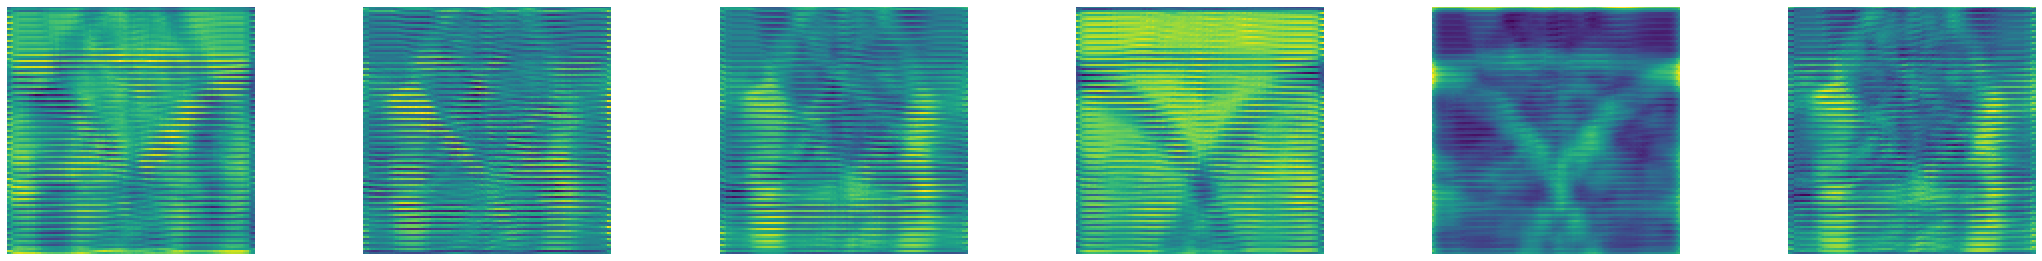

Layer  2


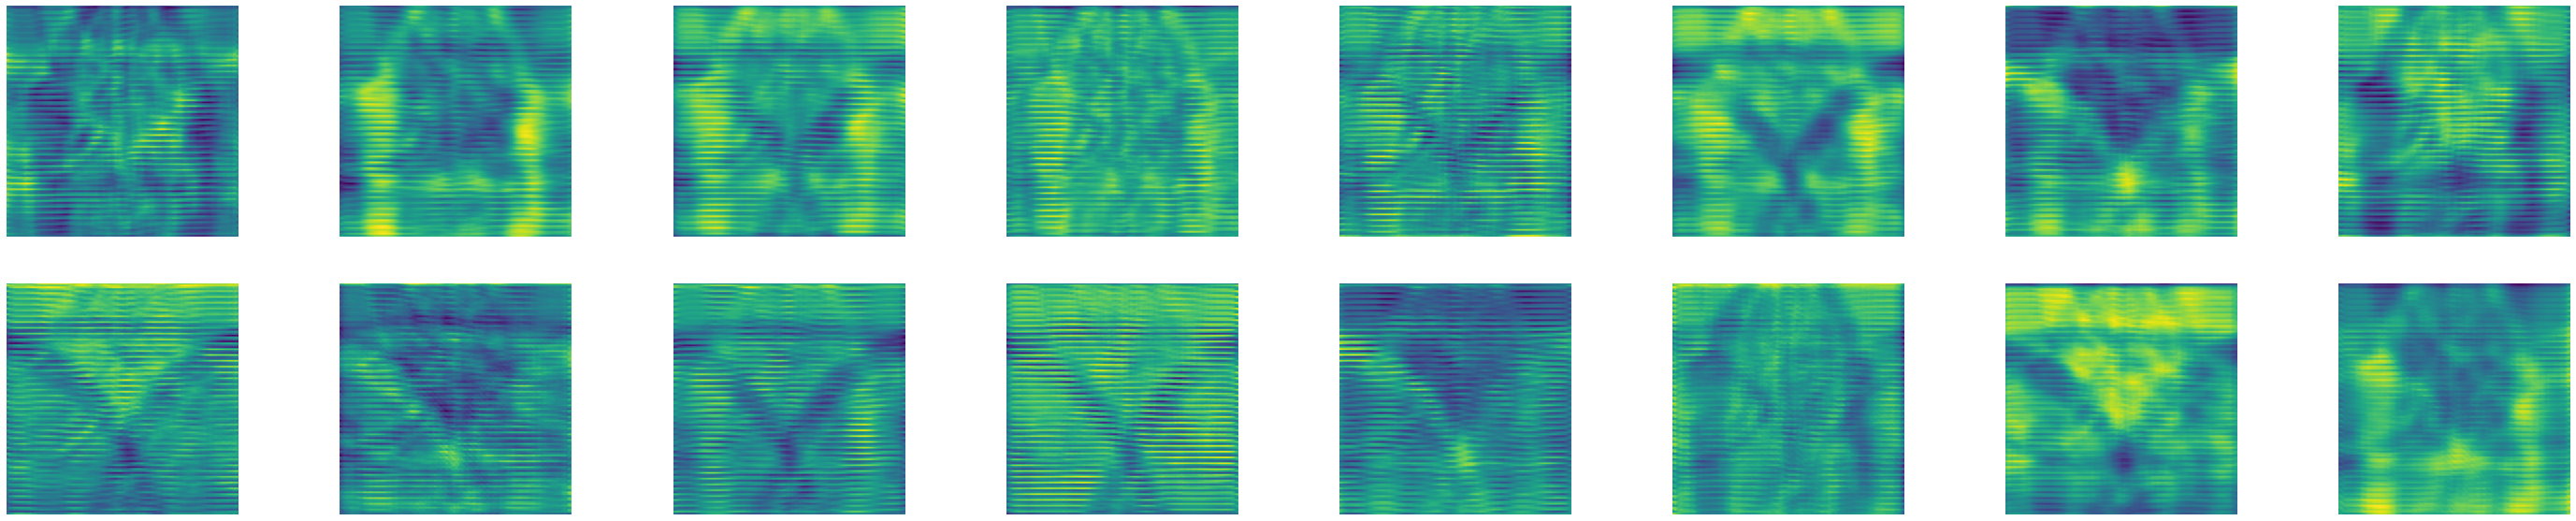

In [53]:
for num_layer in range(len(outputs)):
    plt.figure(figsize=(50, 10))
    layer_viz = outputs[num_layer].squeeze()
    print("Layer ",num_layer+1)
    for i, f in enumerate(layer_viz):
        plt.subplot(2, 8, i + 1)
        plt.imshow(f.detach().cpu().numpy())
        plt.axis("off")
    plt.show()
    plt.close()

# Are We Over-fitting?

## Preparing a validation set: We need to change the MRI dataset slightly!

We will need to make changes to our **MRI dataset class**:

- Define a function to divide the data into train and validation sets
- Define a variable called **mode** to determine whether we are interested in the training OR validation data
- Change __len()__ and __getitem__() functions and conditioned over the variable **mode**

In [3]:
# Import train/test split function from sklearn
from sklearn.model_selection import train_test_split

In [38]:
class MRI(Dataset):
    
    def __init__(self):
        
        # Variables to hold the Training data and Validation data
        self.X_train, self.y_train, self.X_val, self.y_val = None, None, None, None
        
        # A variable to determine if we are interested in retrieving the training OR the validation data
        self.mode = 'train'
        
        tumor = []
        healthy = []
        # cv2 - It reads in BGR format by default
        for f in glob.iglob("./data/brain_tumor_dataset/yes/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) # I can add this later in the boot-camp for more adventure
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1])) # otherwise the shape will be (h,w,#channels)
            tumor.append(img)

        for f in glob.iglob("./data/brain_tumor_dataset/no/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) 
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            healthy.append(img)

        # our images
        tumor = np.array(tumor,dtype=np.float32)
        healthy = np.array(healthy,dtype=np.float32)
        
        # our labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)
        
        # Concatenates
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))
    
    # Define a function that would separate the data into Training and Validation sets
    def train_val_split(self):
        self.X_train, self.X_val, self.y_train, self.y_val = \
        train_test_split(self.images, self.labels, test_size=0.20, random_state=42)
        
    def __len__(self):
        # Use self.mode to deetrmine whether train or val data is of interest
        if self.mode == 'train':
            return self.X_train.shape[0]
        elif self.mode == 'val':
            return self.X_val.shape[0]
    
    def __getitem__(self, idx):
        # Use self.mode to deetrmine whether train or val data is of interest
        if self.mode== 'train':
            sample = {'image': self.X_train[idx], 'label': self.y_train[idx]}
        
        elif self.mode== 'val':
            sample = {'image': self.X_val[idx], 'label': self.y_val[idx]}
        
        return sample
    
    def normalize(self):
        self.images = self.images/255.0

# Are we overfitting?

In [39]:
mri_dataset = MRI()
mri_dataset.normalize()
mri_dataset.train_val_split()

In [40]:
train_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

In [41]:
device = torch.device("cuda:0")
model = CNN().to(device)

In [42]:
eta=0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=eta)

In [43]:
# keep track of epoch losses
epoch_train_loss = []
epoch_val_loss = []

In [44]:
for epoch in range(1,600):
    train_losses = []
    # train for the current epoch
    model.train()
    mri_dataset.mode = 'train'
    for D in train_dataloader:
        # Train the model
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        
        y_hat = model(data)
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    epoch_train_loss.append(np.mean(train_losses))
    
    # validate for the current epoch
    val_losses = []
    model.eval()
    
    mri_dataset.mode = 'val'
    
    with torch.no_grad():
        for D in val_dataloader:            
            data = D['image'].to(device)
            label = D['label'].to(device)
            y_hat = model(data)
            error = nn.BCELoss()
            loss = torch.sum(error(y_hat.squeeze(), label))
            val_losses.append(loss.item())
    
    epoch_val_loss.append(np.mean(val_losses))
    
    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tTrain Loss: {:.6f}\tVal Loss: {:.6f}'.format(epoch+1, np.mean(train_losses),np.mean(val_losses)))
    

C:\Users\mehra\anaconda3\envs\ANN\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 10	Train Loss: 0.607736	Val Loss: 0.589281
Train Epoch: 20	Train Loss: 0.615938	Val Loss: 0.569201
Train Epoch: 30	Train Loss: 0.657488	Val Loss: 0.549388
Train Epoch: 40	Train Loss: 0.530938	Val Loss: 0.538539
Train Epoch: 50	Train Loss: 0.484441	Val Loss: 0.565639
Train Epoch: 60	Train Loss: 0.481309	Val Loss: 0.576114
Train Epoch: 70	Train Loss: 0.529916	Val Loss: 0.574456
Train Epoch: 80	Train Loss: 0.459347	Val Loss: 0.612914
Train Epoch: 90	Train Loss: 0.423896	Val Loss: 0.630223
Train Epoch: 100	Train Loss: 0.497308	Val Loss: 0.632659
Train Epoch: 110	Train Loss: 0.459013	Val Loss: 0.643066
Train Epoch: 120	Train Loss: 0.441159	Val Loss: 0.652753
Train Epoch: 130	Train Loss: 0.417855	Val Loss: 0.665437
Train Epoch: 140	Train Loss: 0.410381	Val Loss: 0.661892
Train Epoch: 150	Train Loss: 0.393313	Val Loss: 0.707225
Train Epoch: 160	Train Loss: 0.342976	Val Loss: 0.671177
Train Epoch: 170	Train Loss: 0.349821	Val Loss: 0.683358
Train Epoch: 180	Train Loss: 0.392520	Va

Text(0, 0.5, 'Loss')

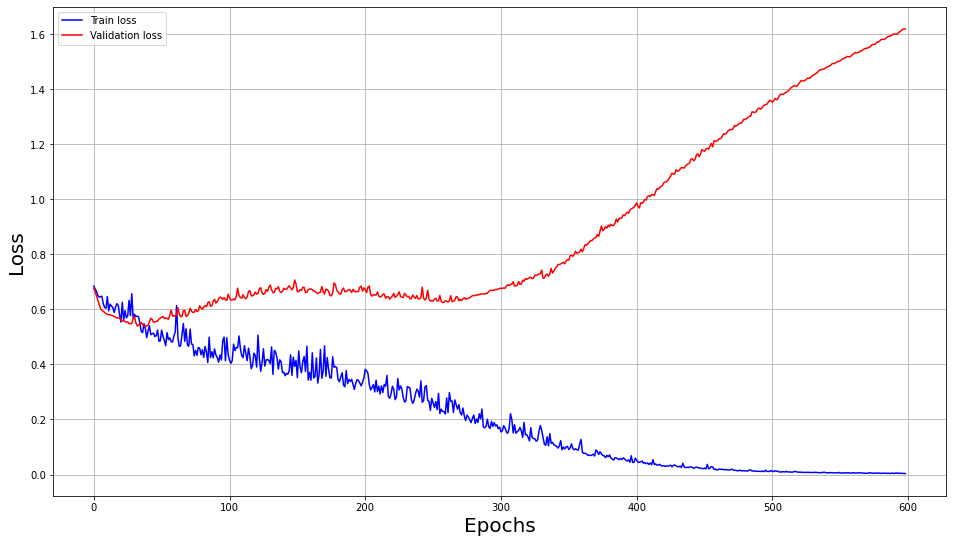

In [45]:
plt.figure(figsize=(16,9))
plt.plot(epoch_train_loss, c='b', label='Train loss')
plt.plot(epoch_val_loss, c='r', label = 'Validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)